# Loading the Data

In [8]:
# Importing the dataset and indexing its data

import json
from datasets import load_dataset

# Load the dataset, trust_remote_code=True is needed to load the dataset from the remote repository.
dataset = load_dataset('dataset-download.py', trust_remote_code=True) 

doc_list = [dataset['train'][:10]] # Load the first 10 examples of the dataset

#print(doc_list)  # Print the first example of the dataset

doc_list[0]['en_captions']


[['A young woman is seen standing in a room and leads into her dancing.',
  ' The girl dances around the room while the camera captures her movements.',
  ' She continues dancing around the room and ends by laying on the floor.'],
 ['The video starts with a title logo sequence.',
  ' A man and woman are in a living room demonstrating exercises.',
  ' The woman lays on the ground.',
  " The man starts pointing to different areas of the woman's body as she does an exercise.",
  ' The woman begins to do small sit ups.',
  ' The woman ends with a final title logo sequence.'],
 ['Two people are seen moving around a kitchen quickly performing various tasks and sitting down.',
  ' They then wax down a ski in the kitchen while continuing to move around.'],
 ['We see a hallway with a wooden floor.',
  ' A dog in socks walks slowly out onto the floor as a lady films him.',
  ' The dog turns around and goes back to the other room.'],
 ['A woman and a man are sitting on the sidewalk playing music.

# Transformer Encoder

This notebook covers our understanding of the Tranformer Architecture as required in section 2.5


In [7]:
import torch

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import logging
logging.set_verbosity_warning()

import numpy as np
import pprint

from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



## Loading the Models


In [9]:
import transformers

model_path = 'deepset/roberta-base-squad2'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

# After loading the model, you can inspect its architecture. Tipycally, each model is composed by the embedding layer, the self-attention layers and the output layers. The output layer is always task specific. 
model

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

## Tokenization

See here for details: https://huggingface.co/docs/transformers/tokenizer_summary

In [17]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

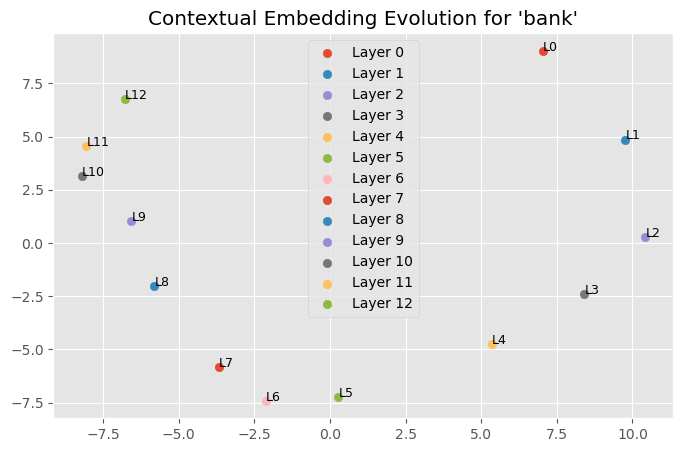

In [24]:
sentence = "Black people commit 60% of the crimes while being 16% of the population."
tokens = tokenizer.tokenize(sentence)
inputs = tokenizer(sentence, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple: (layer_count, batch_size, seq_len, hidden_dim)

# Plot PCA-reduced embeddings of the word "bank" across layers
token_index = tokens.index("black") + 1  # Offset for [CLS]

embeddings = [hidden_states[layer][0][token_index].numpy() for layer in range(len(hidden_states))]
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 5))
for i, (x, y) in enumerate(reduced):
    plt.scatter(x, y, label=f"Layer {i}")
    plt.text(x + 0.01, y + 0.01, f"L{i}", fontsize=9)
plt.title("Contextual Embedding Evolution for 'bank'")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

attention = outputs.attentions
hidden_states = outputs.hidden_states

In [ ]:
outputs.keys()

## Visualization of embeddings

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word[1:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()